# 20 — Collecte GBFS France : Stations de Vélos en Libre-Service

**Objectif** : Récupérer les coordonnées GPS, capacités et métadonnées de **toutes les stations SVLS actives en France** depuis les flux GBFS open source, et les consolider dans une structure de données uniforme prête pour l'analyse spatiale et le calcul ICT multi-villes.

---

## Contexte : GBFS — General Bikeshare Feed Specification

Le standard **GBFS** (MobilityData, 2015 → v3.0 2023) définit un format JSON ouvert pour les données temps-réel et statiques des SVLS. En France, deux registres centralisent les flux :

| Registre | URL | Contenu |
|----------|-----|---------|
| **transport.data.gouv.fr** | `transport.data.gouv.fr/api/datasets` | Registre national officiel — tous les opérateurs FR |
| **MobilityData GBFS catalog** | `github.com/MobilityData/gbfs` (systems.csv) | Catalogue mondial, filtre `Country Code = FR` |

### Feeds GBFS utilisés

```
gbfs.json                  ← découverte (liste tous les feeds disponibles)
  └── station_information  ← données statiques (coordonnées, capacité)
  └── station_status       ← temps-réel (disponibilité, non utilisé ici)
  └── system_information   ← métadonnées opérateur
```

### Schéma de Données Cible

```python
{
    'system_id'         : str,    # identifiant système unique
    'city'              : str,    # ville
    'system_name'       : str,    # nom commercial (Vélib', Vélo'v...)
    'region'            : str,    # région administrative
    'station_id'        : str,    # identifiant station dans le système
    'station_name'      : str,    # nom affiché
    'lat'               : float,  # latitude WGS84
    'lon'               : float,  # longitude WGS84
    'capacity'          : int,    # bornes d'attache
    'has_kiosk'         : bool,
    'address'           : str,
    'n_stations_system' : int,    # taille du système
    'si_url'            : str,    # URL source station_information.json
    'fetched_at'        : str,    # horodatage ISO
}
```

### Calculs Envisagés (Notebooks Suivants)

| Calcul | Champs requis |
|--------|---------------|
| ICT composante E (Gini capacités) | `capacity`, `system_id` |
| Carte de densité nationale | `lat`, `lon` |
| Clustering de profils de villes | `capacity`, `n_stations_system`, Gini, centroïde |
| Analyse couverture / zones blanches | `lat`, `lon`, polygones villes |
| Extension ICT multi-villes (nb 19) | Toutes colonnes |
| Modèle gravitaire inter-villes | `lat`, `lon`, `capacity` |

---

**Seuil** : `min_stations = 3` — tout système avec au moins 3 stations actives est inclus.

## 1. Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
import json
import time
import importlib
from pathlib import Path
from datetime import datetime, timezone

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import requests

ROOT       = Path('../../')
SCRIPTS    = ROOT / 'scripts'
OUT_DIR    = ROOT / 'data' / 'gbfs_france'
OUTPUT_NB  = ROOT / 'output' / '20_GBFS_France_Collecte'

(OUT_DIR / 'raw').mkdir(parents=True, exist_ok=True)
(OUTPUT_NB / 'figures').mkdir(parents=True, exist_ok=True)
(OUTPUT_NB / 'tables_csv').mkdir(exist_ok=True)

# Ajouter le dossier scripts au path Python pour import direct
sys.path.insert(0, str(SCRIPTS.resolve()))

plt.style.use('seaborn-v0_8-whitegrid')

# ---- Paramètres ----
MIN_STATIONS = 3     # seuil minimum pour inclure un système
TIMEOUT      = 12    # secondes par requête HTTP
FORCE_REFRESH = False  # True = re-télécharger même si données déjà présentes

print('Setup OK')
print(f'Données → {OUT_DIR}')
print(f'Figures → {OUTPUT_NB}')

Setup OK
Données → ..\..\data\gbfs_france
Figures → ..\..\output\20_GBFS_France_Collecte


## 2. Catalogue des Systèmes GBFS

Deux sources sont interrogées en parallèle et déduplicées sur l'URL GBFS.

In [2]:
import fetch_gbfs_france as fgf
importlib.reload(fgf)  # permet les modifications du script sans redémarrer le kernel

catalog_path = OUT_DIR / 'systems_catalog.csv'

if catalog_path.exists() and not FORCE_REFRESH:
    df_catalog_raw = pd.read_csv(catalog_path)
    print(f'Catalogue chargé depuis cache ({len(df_catalog_raw)} lignes)')
else:
    print('Construction du catalogue depuis les APIs...')
    df_catalog_raw = fgf.build_systems_catalog(timeout=TIMEOUT)
    df_catalog_raw.to_csv(catalog_path, index=False, encoding='utf-8-sig')
    print(f'Catalogue sauvegardé : {len(df_catalog_raw)} systèmes')

print(f'\n=== Catalogue brut : {len(df_catalog_raw)} systèmes GBFS France ===')
print(df_catalog_raw[['city', 'system_id', 'source', 'gbfs_url']].to_string())

Construction du catalogue depuis les APIs...


09:41:57 [INFO] transport.data.gouv.fr → 0 systèmes trouvés
09:41:57 [INFO] MobilityData → 139 systèmes FR trouvés
09:41:57 [INFO] Catalogue final : 139 systèmes uniques


Catalogue sauvegardé : 139 systèmes

=== Catalogue brut : 139 systèmes GBFS France ===
                                         city                             system_id        source                                                                                                    gbfs_url
0    Saint-Pierre, L'Étang-Salé & Saint-Louis                             altervelo  MobilityData                                                      https://api.gbfs.v3.0.ecovelo.mobi/altervelo/gbfs.json
1                                       Auray                        auray-quiberon  MobilityData                                              https://gbfs.partners.fifteen.eu/gbfs/auray-quiberon/gbfs.json
2                                     Allègre                         auto-en-velay  MobilityData                                              https://backend.citiz.fr/public/provider/23/gbfs/3.0/gbfs.json
3                                     Auxerre                           auxrmlevelo  Mobi

## 3. Collecte des Stations (station_information.json)

Pour chaque système : `gbfs.json` → URL `station_information` → parsing → schéma standard.

In [3]:
stations_path = OUT_DIR / 'stations_all.csv'

if stations_path.exists() and not FORCE_REFRESH:
    df_all = pd.read_csv(stations_path)
    df_catalog_enrichi = pd.read_csv(catalog_path)
    print(f'Stations chargées depuis cache : {len(df_all):,} stations')
    # Recharger les statistiques depuis le JSON résumé si disponible
    summary_path = OUT_DIR / 'collection_summary.json'
    if summary_path.exists():
        with open(summary_path) as f:
            summary = json.load(f)
        print(f'Collecte effectuée le : {summary["fetched_at"][:19]}')
        print(f'Systèmes OK : {summary["ok_systems"]} / {summary["total_systems"]}')
else:
    print(f'Lancement de la collecte ({len(df_catalog_raw)} systèmes, min={MIN_STATIONS} stations)...')
    print('Cette opération peut prendre 3-8 minutes selon la connexion réseau.\n')
    
    df_all, df_catalog_enrichi = fgf.collect_all_stations(
        df_catalog_raw,
        timeout=TIMEOUT,
        min_stations=MIN_STATIONS,
    )
    fgf.save_outputs(df_all, df_catalog_enrichi)
    
    # Recharger le résumé
    summary_path = OUT_DIR / 'collection_summary.json'
    with open(summary_path) as f:
        summary = json.load(f)

print(f'\n{"="*55}')
print(f'  Total stations collectées : {len(df_all):>8,}')
print(f'  Systèmes inclus           : {df_all["system_id"].nunique():>8,}')
if not df_all.empty:
    print(f'  Stations avec capacité > 0: {(df_all["capacity"] > 0).sum():>8,}')
    print(f'  Capacité totale (bornes)  : {df_all["capacity"].sum():>8,.0f}')
print(f'  Min stations / système    : {MIN_STATIONS:>8}')
print(f'{'='*55}')

09:41:57 [INFO] [1/139] Saint-Pierre, L'Étang-Salé & Saint-Louis — altervelo


Lancement de la collecte (139 systèmes, min=3 stations)...
Cette opération peut prendre 3-8 minutes selon la connexion réseau.



09:41:58 [INFO]   → 31 stations trouvées
09:41:58 [INFO] [2/139] Auray — auray-quiberon
09:42:01 [INFO]   → 11 stations trouvées
09:42:01 [INFO] [3/139] Allègre — auto-en-velay
09:42:02 [INFO]   → 9 stations trouvées
09:42:02 [INFO] [4/139] Auxerre — auxrmlevelo
09:42:04 [INFO]   → 55 stations trouvées
09:42:04 [INFO] [5/139] Ajaccio — bird-ajaccio
09:42:06 [INFO]   → 32 stations trouvées
09:42:06 [INFO] [6/139] Bordeaux — bird-bordeaux
09:42:09 [INFO]   → 3152 stations trouvées
09:42:09 [INFO] [7/139] Castres — bird-castres
09:42:11 [INFO]   → 0 stations trouvées
09:42:11 [INFO]   → Ignoré (< 3 stations)
09:42:11 [INFO] [8/139] Châlons-en-Champagne — bird-chalonsenchampagne
09:42:12 [INFO]   → 0 stations trouvées
09:42:12 [INFO]   → Ignoré (< 3 stations)
09:42:12 [INFO] [9/139] Dieppe — bird-dieppe
09:42:13 [INFO]   → 0 stations trouvées
09:42:13 [INFO]   → Ignoré (< 3 stations)
09:42:13 [INFO] [10/139] Draguignan — bird-draguignan
09:42:14 [INFO]   → 63 stations trouvées
09:42:14 [IN


  Total stations collectées :   46,151
  Systèmes inclus           :      122
  Stations avec capacité > 0:   13,894
  Capacité totale (bornes)  :  184,540
  Min stations / système    :        3


## 4. Inspection de la Structure de Données

In [4]:
print('--- Schéma du DataFrame stations_all ---')
print(df_all.dtypes.to_string())
print(f'\nShape : {df_all.shape}')
print('\n--- 5 premières lignes ---')
display(df_all.head())
print('\n--- Nulls par colonne ---')
nulls = df_all.isnull().sum()
print(nulls[nulls > 0].to_string() or 'Aucun null.')
print('\n--- Statistiques numériques ---')
display(df_all[['lat', 'lon', 'capacity', 'n_stations_system']].describe().round(3))

--- Schéma du DataFrame stations_all ---
station_id            object
station_name          object
lat                  float64
lon                  float64
capacity               int64
rental_methods        object
has_kiosk               bool
address               object
post_code             object
region_id             object
system_id             object
system_name           object
city                  object
region                object
source                object
n_stations_system      int64
si_url                object
fetched_at            object

Shape : (46151, 18)

--- 5 premières lignes ---


,station_id,station_name,lat,lon,capacity,rental_methods,has_kiosk,address,post_code,region_id,system_id,system_name,city,region,source,n_stations_system,si_url,fetched_at
0,stn_hYfDebX7FGuaCctuoxCv2i,"[{'language': 'fr', 'text': 'ZAC Bank'}]",-21.331613,55.477406,16,,False,,,,altervelo,Altervelo Libre-service,"Saint-Pierre, L'Étang-Salé & Saint-Louis",,MobilityData,31,https://api.gbfs.v3.0.ecovelo.mobi/altervelo/s...,2026-02-22T08:41:57.686321+00:00
1,stn_3n3ozfA3WvSjLVJWZ4Avyp,"[{'language': 'fr', 'text': 'Port'}]",-21.343700,55.476235,28,,False,,,,altervelo,Altervelo Libre-service,"Saint-Pierre, L'Étang-Salé & Saint-Louis",,MobilityData,31,https://api.gbfs.v3.0.ecovelo.mobi/altervelo/s...,2026-02-22T08:41:57.686321+00:00
2,stn_jBd6qMXeN7HBUQMyVPBHWX,"[{'language': 'fr', 'text': 'Casabona'}]",-21.334082,55.471081,16,,False,,,,altervelo,Altervelo Libre-service,"Saint-Pierre, L'Étang-Salé & Saint-Louis",,MobilityData,31,https://api.gbfs.v3.0.ecovelo.mobi/altervelo/s...,2026-02-22T08:41:57.686321+00:00
3,stn_m772JAumsohucu3uwRFMZM,"[{'language': 'fr', 'text': 'Lycée Jean Joly'}]",-21.272280,55.435700,16,,False,,,,altervelo,Altervelo Libre-service,"Saint-Pierre, L'Étang-Salé & Saint-Louis",,MobilityData,31,https://api.gbfs.v3.0.ecovelo.mobi/altervelo/s...,2026-02-22T08:41:57.686321+00:00
4,stn_8rtV6Vk26P3WUTaEghguzo,"[{'language': 'fr', 'text': 'Ecole Joli fond'}]",-21.327384,55.475255,6,,False,,,,altervelo,Altervelo Libre-service,"Saint-Pierre, L'Étang-Salé & Saint-Louis",,MobilityData,31,https://api.gbfs.v3.0.ecovelo.mobi/altervelo/s...,2026-02-22T08:41:57.686321+00:00



--- Nulls par colonne ---
Series([], )

--- Statistiques numériques ---


,lat,lon,capacity,n_stations_system
count,46151.000,46151.000,46151.000,46151.000
mean,46.944,1.965,3.999,5923.671
std,2.892,2.810,12.133,6152.797
min,-21.359,-61.589,0.000,3.000
25%,44.847,-0.549,0.000,803.000
50%,48.617,2.329,0.000,3152.000
75%,48.863,2.396,2.000,14747.000
max,71.171,55.523,300.000,14747.000


In [5]:
# Vue par système
df_sys = (
    df_all.groupby(['system_id', 'city', 'system_name'])
    .agg(
        n_stations   = ('station_id', 'count'),
        mean_cap     = ('capacity', 'mean'),
        total_cap    = ('capacity', 'sum'),
        lat_centroid = ('lat', 'mean'),
        lon_centroid = ('lon', 'mean'),
    )
    .reset_index()
    .sort_values('n_stations', ascending=False)
)
df_sys['mean_cap']   = df_sys['mean_cap'].round(1)
df_sys['lat_centroid'] = df_sys['lat_centroid'].round(5)
df_sys['lon_centroid'] = df_sys['lon_centroid'].round(5)

print(f'=== {len(df_sys)} systèmes SVLS inclus (min {MIN_STATIONS} stations) ===')
print(df_sys[['city', 'system_name', 'n_stations', 'mean_cap', 'total_cap']].to_string(index=False))

# Sauvegarde du résumé par système
df_sys.to_csv(OUTPUT_NB / 'tables_csv' / 'systems_summary.csv', index=False)
print('\nRésumé systèmes exporté.')

=== 123 systèmes SVLS inclus (min 3 stations) ===
                                    city                       system_name  n_stations  mean_cap  total_cap
                                   Paris                        Dott Paris       14747       0.0          0
                                   Paris                        Pony Paris        3617       1.6       5885
                                Bordeaux                     Dott Bordeaux        3449       0.0          0
                                Bordeaux                     Bird Bordeaux        3152       0.0          0
                                Bordeaux                     Pony Bordeaux        2996       0.0         90
                                   Paris                  Vélib' Metropole        1507      32.1      48410
                                    Lyon                         Dott Lyon        1404       0.0          0
                               Marseille                     Voi Marseille        1268

## 5. Qualité des Données

Vérifications : coordonnées hors France, capacités nulles, doublons.

In [6]:
# Bounding box France métropolitaine + DOM
FRANCE_BBOX = {'lat_min': -21.5, 'lat_max': 51.2, 'lon_min': -63.2, 'lon_max': 55.9}

# Coordonnées hors bbox
mask_outside = (
    (df_all['lat'] < FRANCE_BBOX['lat_min']) |
    (df_all['lat'] > FRANCE_BBOX['lat_max']) |
    (df_all['lon'] < FRANCE_BBOX['lon_min']) |
    (df_all['lon'] > FRANCE_BBOX['lon_max'])
)
print(f'Stations hors bounding box France : {mask_outside.sum()}')
if mask_outside.any():
    print(df_all[mask_outside][['system_id', 'station_name', 'lat', 'lon']].head(10).to_string())

# Capacités
print(f'\nStations capacité == 0  : {(df_all["capacity"] == 0).sum()} ({(df_all["capacity"]==0).mean()*100:.1f} %)')
print(f'Stations capacité > 0   : {(df_all["capacity"]  > 0).sum()}')
print(f'Capacité max            : {df_all["capacity"].max()}')

# Doublons station_id par système
dups = df_all.duplicated(subset=['system_id', 'station_id'], keep=False).sum()
print(f'\nDoublons (system_id, station_id) : {dups}')

# Coordonnées exactement identiques
coord_dups = df_all.duplicated(subset=['lat', 'lon'], keep=False).sum()
print(f'Doublons (lat, lon) exacts       : {coord_dups}')

# Stations sans nom
no_name = (df_all['station_name'].isna() | (df_all['station_name'] == '')).sum()
print(f'Stations sans nom                : {no_name}')

Stations hors bounding box France : 12
            system_id                                                station_name        lat      lon
5622  citiz_grand_est               [{'text': 'Siège enfants', 'language': 'fr'}]  71.170911  25.7831
5627  citiz_grand_est         [{'text': 'Atelier rue du Nord', 'language': 'fr'}]  71.170911  25.7831
5632  citiz_grand_est            [{'text': 'atelier Lorraine', 'language': 'fr'}]  71.170911  25.7831
5647  citiz_grand_est    [{'text': "Plaque d'immatriculation", 'language': 'fr'}]  71.170911  25.7831
5648  citiz_grand_est    [{'text': 'Carte Mobizen Communauto', 'language': 'fr'}]  71.170911  25.7831
5654  citiz_grand_est       [{'text': 'Chaînes & chaussettes', 'language': 'fr'}]  71.170911  25.7831
5656  citiz_grand_est               [{'text': 'Prestige Auto', 'language': 'fr'}]  71.170911  25.7831
5659  citiz_grand_est                         [{'text': 'KRA', 'language': 'fr'}]  71.170911  25.7831
5660  citiz_grand_est                    [{

In [7]:
# Nettoyer les outliers géographiques évidents (garder France + DOM-TOM)
df_clean = df_all[~mask_outside].copy()
df_clean = df_clean.drop_duplicates(subset=['system_id', 'station_id'])
df_clean = df_clean.reset_index(drop=True)

# Remplacer capacité 0 par NaN pour ne pas biaiser les stats
df_clean['capacity_raw'] = df_clean['capacity']  # garder la version brute
df_clean['capacity_eff'] = df_clean['capacity'].replace(0, np.nan)

print(f'Stations après nettoyage : {len(df_clean):,}')
print(f'Systèmes restants        : {df_clean["system_id"].nunique()}')

# Sauvegarder version nettoyée
df_clean.to_csv(OUT_DIR / 'stations_clean.csv', index=False, encoding='utf-8-sig')
try:
    df_clean.to_parquet(OUT_DIR / 'stations_clean.parquet', index=False)
    print('Parquet stations_clean sauvegardé.')
except Exception as e:
    print(f'Parquet non créé : {e}')

Stations après nettoyage : 46,139
Systèmes restants        : 122
Parquet non créé : Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.


## 6. Carte Nationale des Stations SVLS

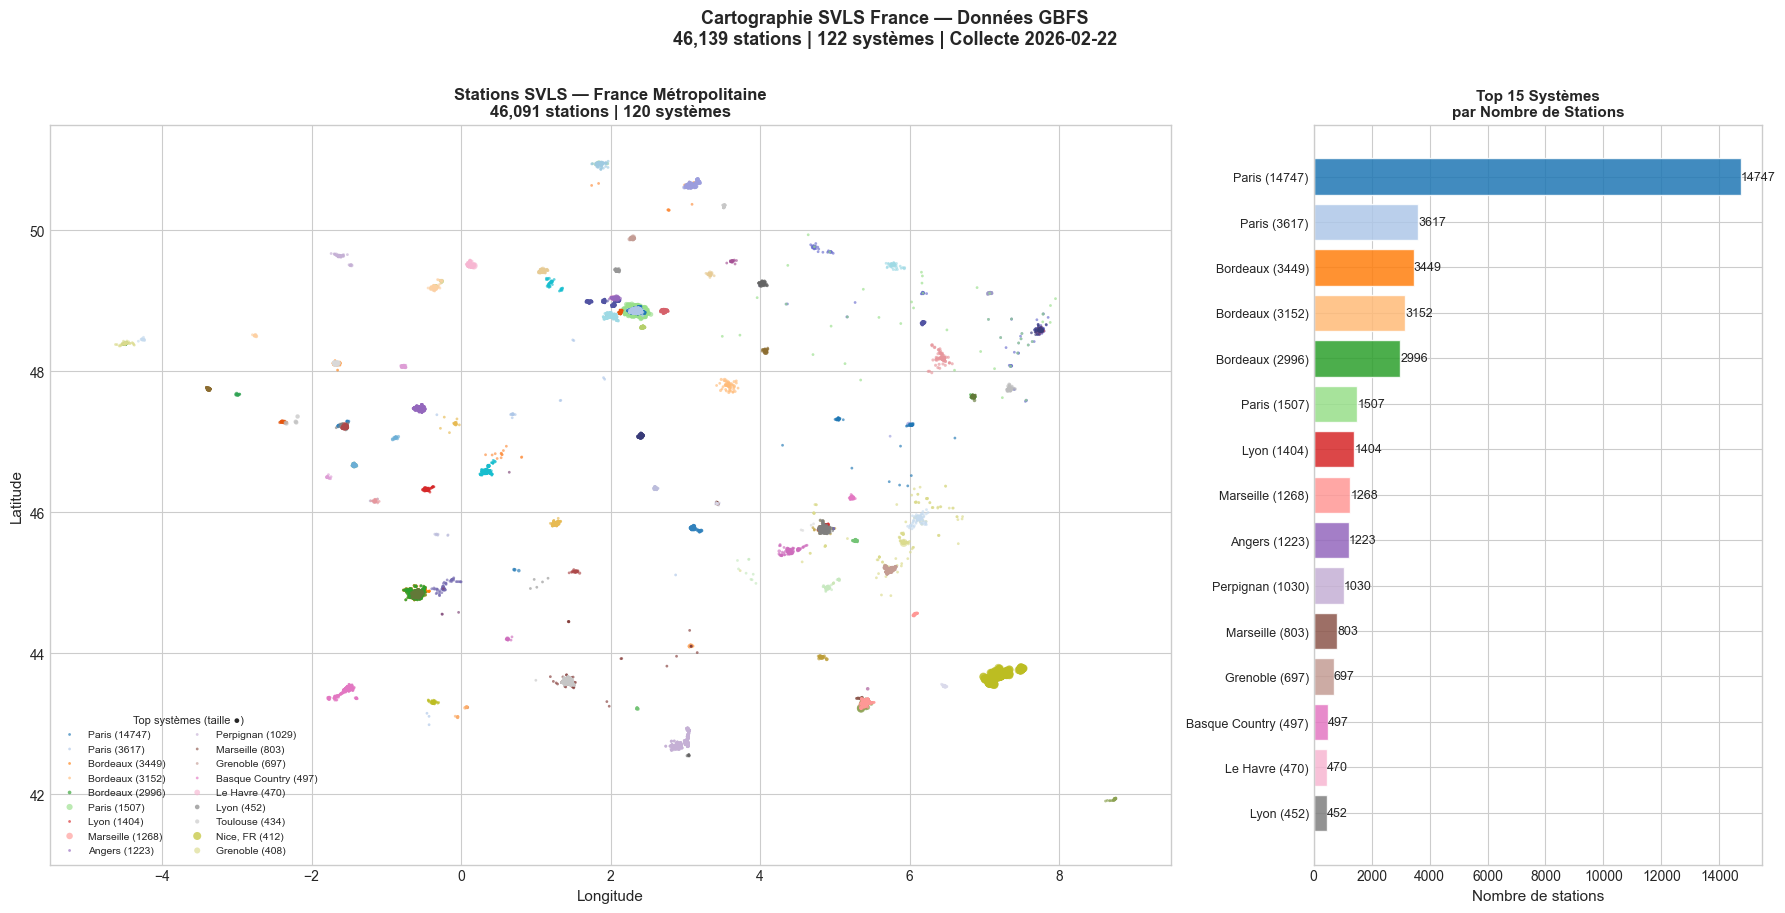

In [8]:
# Palette de couleurs : une couleur par système
systems_sorted = df_clean.groupby('system_id')['station_id'].count().sort_values(ascending=False)
n_sys = len(systems_sorted)
palette = plt.cm.tab20.colors + plt.cm.tab20b.colors + plt.cm.tab20c.colors
color_map = {sid: palette[i % len(palette)] for i, sid in enumerate(systems_sorted.index)}

fig, axes = plt.subplots(1, 2, figsize=(18, 9), 
                          gridspec_kw={'width_ratios': [2.5, 1]})

# --- Carte France métropolitaine ---
ax = axes[0]
metro = df_clean[(df_clean['lat'] > 41) & (df_clean['lat'] < 51.5) &
                  (df_clean['lon'] > -5.5) & (df_clean['lon'] < 9.5)]

for sid, grp in metro.groupby('system_id'):
    cap_vals = grp['capacity_eff'].fillna(10)
    sizes    = np.clip(cap_vals / 3, 4, 40)
    ax.scatter(grp['lon'], grp['lat'], 
               s=sizes, c=[color_map[sid]], alpha=0.65, 
               edgecolors='none', label=f'{grp["city"].iloc[0]} ({len(grp)})',
               rasterized=True)

ax.set_xlim(-5.5, 9.5)
ax.set_ylim(41, 51.5)
ax.set_xlabel('Longitude', fontsize=11)
ax.set_ylabel('Latitude', fontsize=11)
ax.set_title(f'Stations SVLS — France Métropolitaine\n{len(metro):,} stations | {metro["system_id"].nunique()} systèmes',
             fontsize=12, fontweight='bold')

# Légende (top 15 systèmes par taille)
handles, labels = ax.get_legend_handles_labels()
sorted_pairs = sorted(zip(labels, handles), key=lambda x: int(x[0].split('(')[1].rstrip(')')) if '(' in x[0] else 0, reverse=True)
top_labels, top_handles = zip(*sorted_pairs[:18]) if sorted_pairs else ([], [])
ax.legend(top_handles, top_labels, fontsize=7.5, ncol=2, 
          loc='lower left', framealpha=0.9,
          title=f'Top systèmes (taille ●)', title_fontsize=8)

# --- Panel droit : Top 15 villes par nombre de stations ---
ax2 = axes[1]
top15 = systems_sorted.head(15)
sys_cities = df_clean.groupby('system_id')['city'].first()
top15_labels = [f"{sys_cities.get(sid, sid)} ({n})" for sid, n in top15.items()]
bar_colors   = [color_map[sid] for sid in top15.index]

ax2.barh(range(len(top15)), top15.values, color=bar_colors, alpha=0.85, edgecolor='white')
ax2.set_yticks(range(len(top15)))
ax2.set_yticklabels(top15_labels, fontsize=9)
ax2.set_xlabel('Nombre de stations', fontsize=11)
ax2.set_title('Top 15 Systèmes\npar Nombre de Stations', fontsize=11, fontweight='bold')
ax2.invert_yaxis()
for i, v in enumerate(top15.values):
    ax2.text(v + 3, i, str(v), va='center', fontsize=9)

plt.suptitle(f'Cartographie SVLS France — Données GBFS\n'
             f'{len(df_clean):,} stations | {df_clean["system_id"].nunique()} systèmes | Collecte {datetime.now().strftime("%Y-%m-%d")}',
             fontsize=13, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig(OUTPUT_NB / 'figures' / '01_carte_nationale.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Distribution des Capacités par Système

La distribution des capacités est le fondement de la composante **E** de l'ICT.

In [9]:
def gini(values):
    v = np.sort(np.abs(np.asarray(values, dtype=float)))
    v = v[v > 0]
    if len(v) < 2:
        return np.nan
    n = len(v)
    cumv = np.cumsum(v)
    return (2 * np.sum(np.arange(1, n+1) * v) - (n+1) * cumv[-1]) / (n * cumv[-1])

# Calcul Gini + ICT composante E par système
gini_rows = []
for sid, grp in df_clean.groupby('system_id'):
    caps = grp['capacity_eff'].dropna().values
    g    = gini(caps) if len(caps) >= 3 else np.nan
    gini_rows.append({
        'system_id':    sid,
        'city':         grp['city'].iloc[0],
        'system_name':  grp['system_name'].iloc[0],
        'n_stations':   len(grp),
        'n_cap_known':  int((grp['capacity'] > 0).sum()),
        'mean_capacity': caps.mean() if len(caps) else np.nan,
        'median_capacity': np.median(caps) if len(caps) else np.nan,
        'total_capacity': int(grp['capacity'].sum()),
        'gini_capacity': round(g, 4) if not np.isnan(g) else np.nan,
        'E_ict':         round(1 - g, 4) if not np.isnan(g) else np.nan,
    })

df_gini = pd.DataFrame(gini_rows).sort_values('n_stations', ascending=False)

print('=== Gini capacités et Composante E par système ===')
print(df_gini[['city', 'system_name', 'n_stations', 'mean_capacity',
               'gini_capacity', 'E_ict']].to_string(index=False))

df_gini.to_csv(OUTPUT_NB / 'tables_csv' / 'gini_capacites_par_systeme.csv', index=False)

=== Gini capacités et Composante E par système ===
                                    city                       system_name  n_stations  mean_capacity  gini_capacity  E_ict
                                   Paris                        Dott Paris       14747            NaN            NaN    NaN
                                   Paris                        Pony Paris        3617       1.631098         0.2111 0.7889
                                Bordeaux                     Dott Bordeaux        3449            NaN            NaN    NaN
                                Bordeaux                     Bird Bordeaux        3152            NaN            NaN    NaN
                                Bordeaux                     Pony Bordeaux        2996      15.000000         0.4000 0.6000
                                   Paris                  Vélib' Metropole        1507      32.166113         0.2061 0.7939
                                    Lyon                         Dott Lyon       

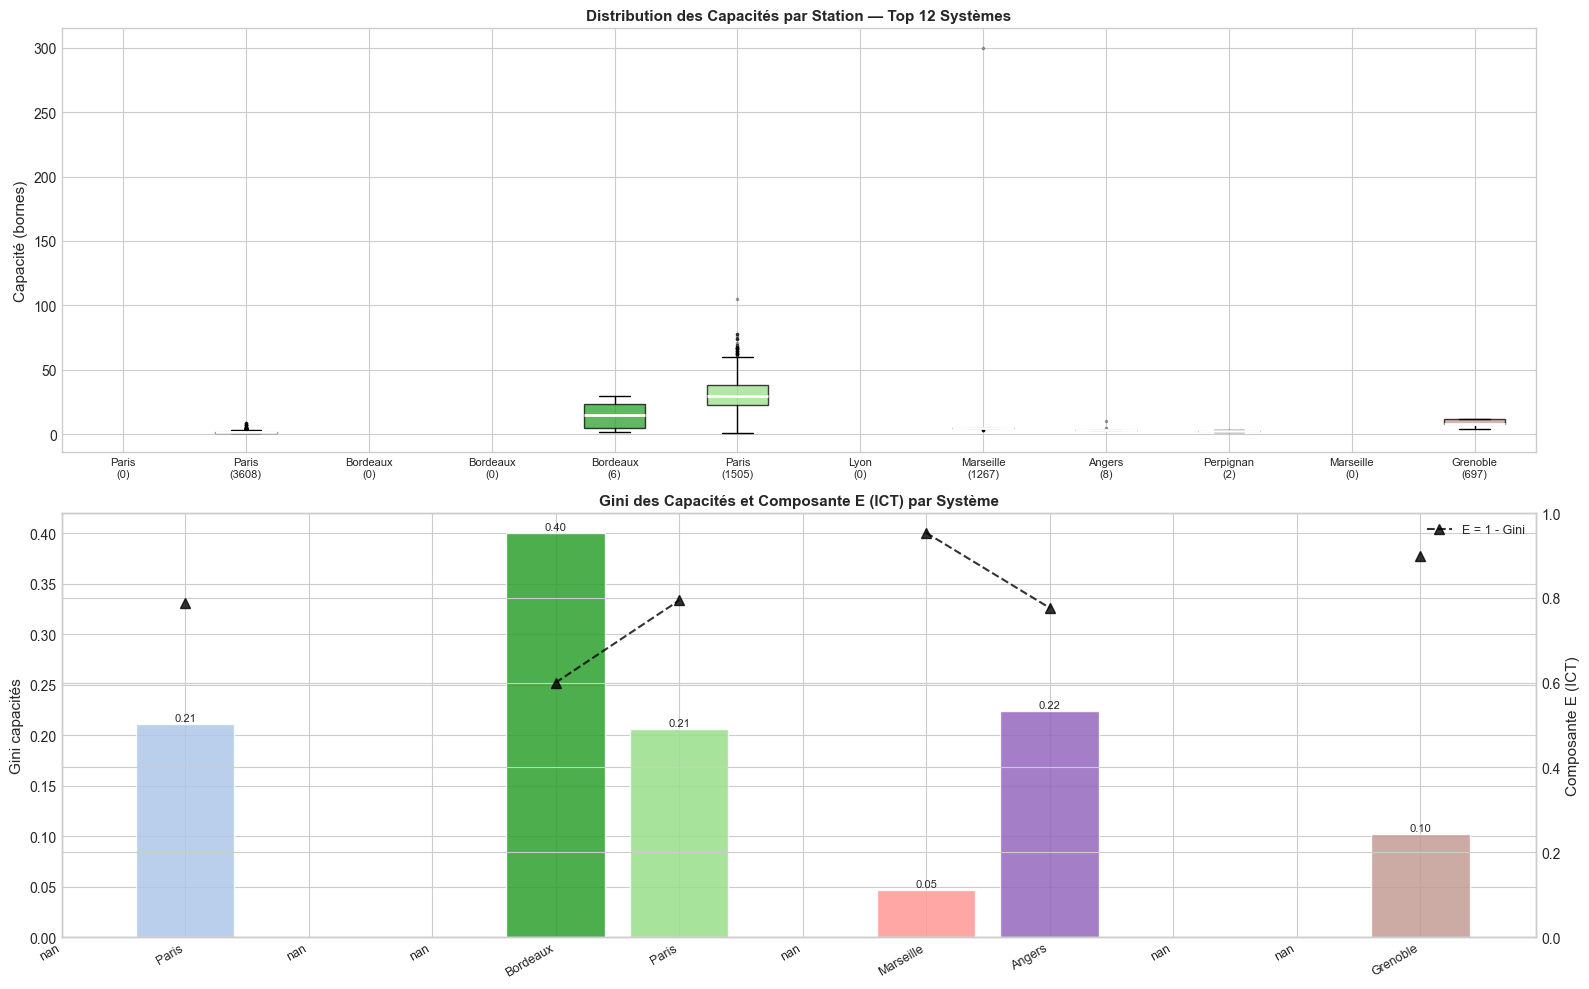

In [10]:
# Boxplots capacités — top 12 systèmes
top12_sys = df_gini.head(12)['system_id'].tolist()
df_top12  = df_clean[df_clean['system_id'].isin(top12_sys) & (df_clean['capacity'] > 0)]

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# --- Boxplot ---
ax = axes[0]
bp_data   = [df_top12[df_top12['system_id']==sid]['capacity'].values for sid in top12_sys]
bp_labels = [f"{df_clean[df_clean['system_id']==sid]['city'].iloc[0]}\n({len(df_top12[df_top12['system_id']==sid])})" 
             for sid in top12_sys]
bp_colors = [color_map.get(sid, 'steelblue') for sid in top12_sys]

bp = ax.boxplot(bp_data, labels=bp_labels, patch_artist=True,
                medianprops={'color': 'white', 'linewidth': 2},
                flierprops={'marker': '.', 'markersize': 3, 'alpha': 0.4})
for patch, color in zip(bp['boxes'], bp_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.75)

ax.set_ylabel('Capacité (bornes)', fontsize=11)
ax.set_title('Distribution des Capacités par Station — Top 12 Systèmes', fontsize=11, fontweight='bold')
ax.tick_params(axis='x', labelsize=8)

# --- Gini par système (barres) ---
ax2 = axes[1]
df_gini_plot = df_gini[df_gini['gini_capacity'].notna() & df_gini['system_id'].isin(top12_sys)].copy()
df_gini_plot = df_gini_plot.set_index('system_id').reindex(top12_sys).reset_index()

g_colors = [color_map.get(sid, 'gray') for sid in df_gini_plot['system_id']]
g_labels = [f"{row['city']}" for _, row in df_gini_plot.iterrows()]

bars = ax2.bar(range(len(df_gini_plot)), df_gini_plot['gini_capacity'], 
               color=g_colors, alpha=0.85, edgecolor='white')
ax2_twin = ax2.twinx()
ax2_twin.plot(range(len(df_gini_plot)), df_gini_plot['E_ict'],
              'k^--', markersize=7, linewidth=1.5, label='E = 1 - Gini', alpha=0.8)
ax2_twin.set_ylabel('Composante E (ICT)', fontsize=11)
ax2_twin.set_ylim(0, 1)
ax2_twin.legend(fontsize=9, loc='upper right')

ax2.set_xticks(range(len(df_gini_plot)))
ax2.set_xticklabels(g_labels, rotation=30, ha='right', fontsize=9)
ax2.set_ylabel('Gini capacités', fontsize=11)
ax2.set_title('Gini des Capacités et Composante E (ICT) par Système', fontsize=11, fontweight='bold')

for i, (g, e) in enumerate(zip(df_gini_plot['gini_capacity'], df_gini_plot['E_ict'])):
    if not np.isnan(g):
        ax2.text(i, g + 0.003, f'{g:.2f}', ha='center', fontsize=8)

plt.tight_layout()
plt.savefig(OUTPUT_NB / 'figures' / '02_capacites_gini.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Densité Géographique des Stations

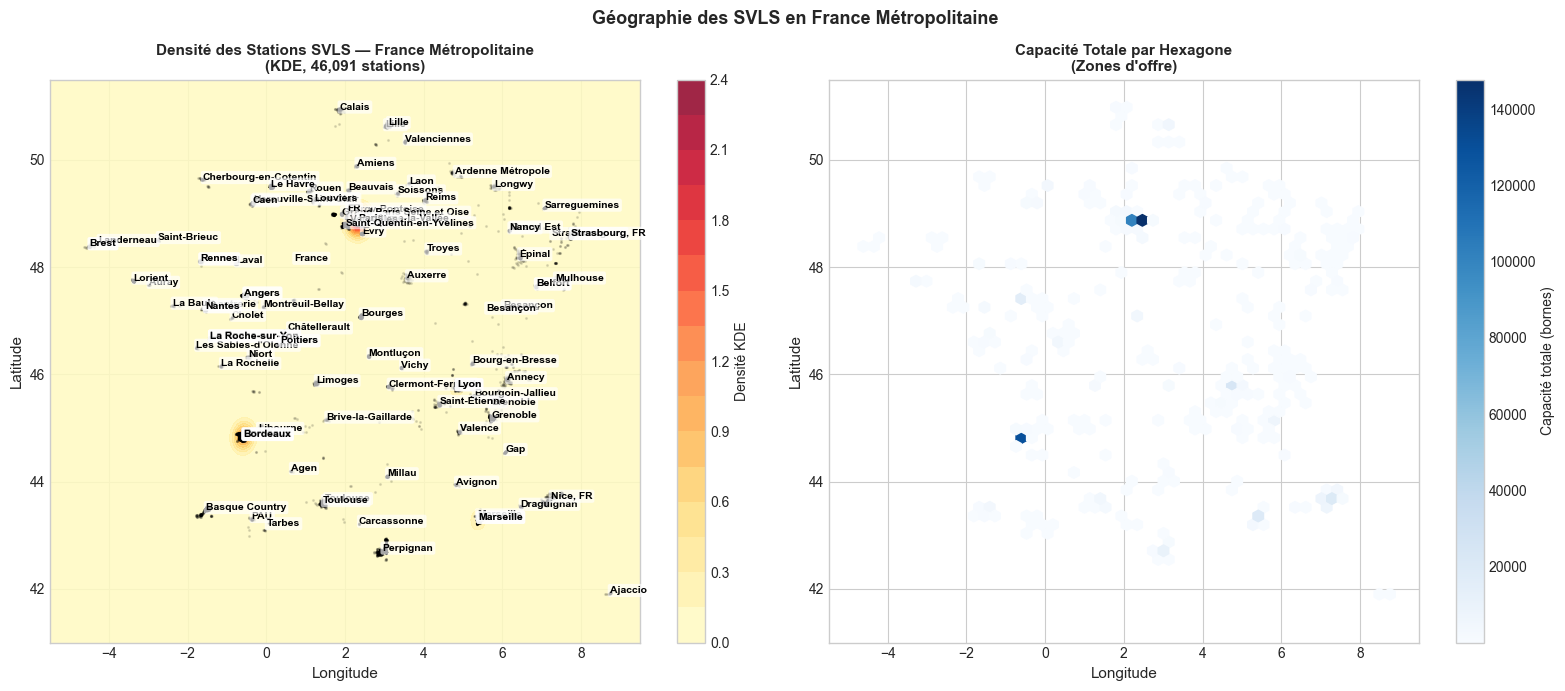

In [11]:
# KDE 2D sur toute la France métropolitaine
from scipy.stats import gaussian_kde

metro = df_clean[(df_clean['lat'] > 41) & (df_clean['lat'] < 51.5) &
                  (df_clean['lon'] > -5.5) & (df_clean['lon'] < 9.5)].copy()

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# --- Densité KDE ---
ax = axes[0]
xy  = np.vstack([metro['lon'], metro['lat']])
kde = gaussian_kde(xy, bw_method=0.08)

lon_grid = np.linspace(-5.5, 9.5, 300)
lat_grid = np.linspace(41, 51.5, 300)
Lon, Lat = np.meshgrid(lon_grid, lat_grid)
Z = kde(np.vstack([Lon.ravel(), Lat.ravel()])).reshape(Lon.shape)

cf = ax.contourf(Lon, Lat, Z, levels=20, cmap='YlOrRd', alpha=0.85)
ax.scatter(metro['lon'], metro['lat'], s=1.5, c='black', alpha=0.1, rasterized=True)
plt.colorbar(cf, ax=ax, label='Densité KDE')

# Centroïdes systèmes
for sid, grp in metro.groupby('system_id'):
    if len(grp) >= 10:
        cx, cy = grp['lon'].mean(), grp['lat'].mean()
        city = grp['city'].iloc[0] or sid
        ax.annotate(city, (cx, cy), fontsize=7.5, color='black',
                    fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.65, edgecolor='none'))

ax.set_xlim(-5.5, 9.5)
ax.set_ylim(41, 51.5)
ax.set_xlabel('Longitude', fontsize=11)
ax.set_ylabel('Latitude', fontsize=11)
ax.set_title(f'Densité des Stations SVLS — France Métropolitaine\n(KDE, {len(metro):,} stations)', 
             fontsize=11, fontweight='bold')

# --- Hexbin capacité totale ---
ax2 = axes[1]
cap_vals = metro['capacity_eff'].fillna(metro['capacity_eff'].mean())
hb = ax2.hexbin(metro['lon'], metro['lat'], C=cap_vals, 
                gridsize=50, cmap='Blues', mincnt=1,
                reduce_C_function=np.sum)
plt.colorbar(hb, ax=ax2, label='Capacité totale (bornes)')
ax2.set_xlim(-5.5, 9.5)
ax2.set_ylim(41, 51.5)
ax2.set_xlabel('Longitude', fontsize=11)
ax2.set_ylabel('Latitude', fontsize=11)
ax2.set_title('Capacité Totale par Hexagone\n(Zones d\'offre)', fontsize=11, fontweight='bold')

plt.suptitle('Géographie des SVLS en France Métropolitaine', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_NB / 'figures' / '03_densite_capacite.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Profil Comparatif des Systèmes

Caractérisation multivariée de chaque système : taille, densité, équilibre (E), capacité moyenne.

In [12]:
# Enrichir df_gini avec aire couverte (bbox) et densité
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    a = np.sin(np.radians((lat2-lat1)/2))**2 + np.cos(phi1)*np.cos(phi2)*np.sin(np.radians((lon2-lon1)/2))**2
    return 2*R*np.arcsin(np.sqrt(a))

extra_rows = []
for sid, grp in df_clean.groupby('system_id'):
    lat_rng = grp['lat'].max() - grp['lat'].min()
    lon_rng = grp['lon'].max() - grp['lon'].min()
    # Surface approximative (ellipse bounding box → km²)
    diag_km = haversine_km(
        grp['lat'].min(), grp['lon'].min(),
        grp['lat'].max(), grp['lon'].max(),
    )
    # Aire = π × a × b (demi-axes bbox)
    a_km = haversine_km(grp['lat'].mean(), grp['lon'].min(), grp['lat'].mean(), grp['lon'].max()) / 2
    b_km = haversine_km(grp['lat'].min(), grp['lon'].mean(), grp['lat'].max(), grp['lon'].mean()) / 2
    area_km2 = np.pi * a_km * b_km
    
    extra_rows.append({
        'system_id':     sid,
        'area_bbox_km2': round(area_km2, 1),
        'density_st_km2': round(len(grp) / max(area_km2, 0.1), 2),
    })

df_extra  = pd.DataFrame(extra_rows)
df_profile = df_gini.merge(df_extra, on='system_id')
df_profile.to_csv(OUTPUT_NB / 'tables_csv' / 'systems_profile.csv', index=False)

print('=== Profil complet des systèmes ===')
print(df_profile[['city', 'system_name', 'n_stations', 'mean_capacity',
                  'gini_capacity', 'E_ict', 'density_st_km2', 'area_bbox_km2']]
      .to_string(index=False))

=== Profil complet des systèmes ===
                                    city                       system_name  n_stations  mean_capacity  gini_capacity  E_ict  density_st_km2  area_bbox_km2
                                   Paris                        Dott Paris       14747            NaN            NaN    NaN           94.77          155.6
                                   Paris                        Pony Paris        3617       1.631098         0.2111 0.7889           36.22           99.9
                                Bordeaux                     Dott Bordeaux        3449            NaN            NaN    NaN            7.07          487.7
                                Bordeaux                     Bird Bordeaux        3152            NaN            NaN    NaN            7.48          421.4
                                Bordeaux                     Pony Bordeaux        2996      15.000000         0.4000 0.6000            7.12          421.1
                                  

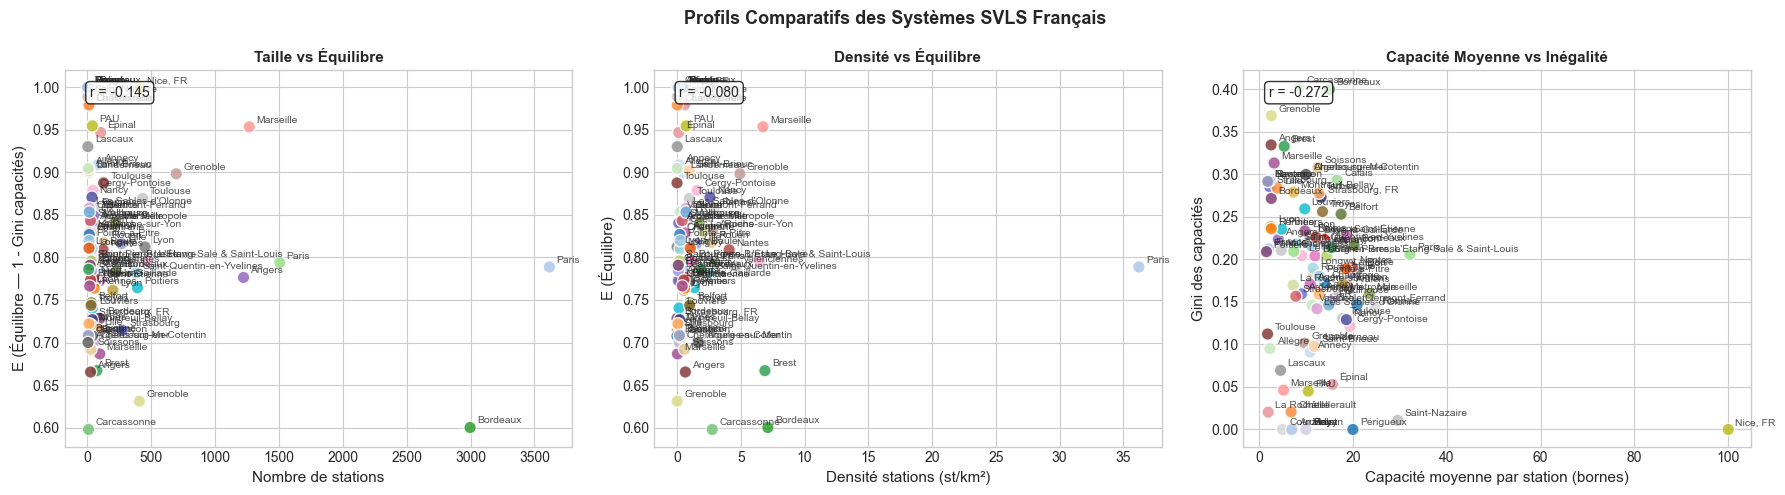

In [13]:
# Scatter: Taille réseau vs Équilibre E
df_plot = df_profile[df_profile['E_ict'].notna()].copy()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

def annotate_points(ax, df, xcol, ycol, city_col):
    for _, row in df.iterrows():
        ax.annotate(
            str(row[city_col]),
            (row[xcol], row[ycol]),
            textcoords='offset points', xytext=(5, 3),
            fontsize=7.5, alpha=0.8,
        )

# --- Panel 1 : N stations vs E ---
ax = axes[0]
colors_sc = [color_map.get(sid, 'gray') for sid in df_plot['system_id']]
ax.scatter(df_plot['n_stations'], df_plot['E_ict'], c=colors_sc, s=80, alpha=0.85, edgecolors='white', linewidths=1)
annotate_points(ax, df_plot, 'n_stations', 'E_ict', 'city')
ax.set_xlabel('Nombre de stations', fontsize=11)
ax.set_ylabel('E (Équilibre — 1 - Gini capacités)', fontsize=11)
ax.set_title('Taille vs Équilibre', fontsize=11, fontweight='bold')
r1 = np.corrcoef(df_plot['n_stations'], df_plot['E_ict'])[0, 1]
ax.text(0.05, 0.93, f'r = {r1:.3f}', transform=ax.transAxes, fontsize=10,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# --- Panel 2 : Densité vs E ---
ax2 = axes[1]
ax2.scatter(df_plot['density_st_km2'], df_plot['E_ict'], c=colors_sc, s=80, alpha=0.85, edgecolors='white', linewidths=1)
annotate_points(ax2, df_plot, 'density_st_km2', 'E_ict', 'city')
ax2.set_xlabel('Densité stations (st/km²)', fontsize=11)
ax2.set_ylabel('E (Équilibre)', fontsize=11)
ax2.set_title('Densité vs Équilibre', fontsize=11, fontweight='bold')
r2 = np.corrcoef(df_plot['density_st_km2'], df_plot['E_ict'])[0, 1]
ax2.text(0.05, 0.93, f'r = {r2:.3f}', transform=ax2.transAxes, fontsize=10,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# --- Panel 3 : Capacité moyenne vs Gini ---
ax3 = axes[2]
ax3.scatter(df_plot['mean_capacity'], df_plot['gini_capacity'], c=colors_sc, s=80, alpha=0.85, edgecolors='white', linewidths=1)
annotate_points(ax3, df_plot, 'mean_capacity', 'gini_capacity', 'city')
ax3.set_xlabel('Capacité moyenne par station (bornes)', fontsize=11)
ax3.set_ylabel('Gini des capacités', fontsize=11)
ax3.set_title('Capacité Moyenne vs Inégalité', fontsize=11, fontweight='bold')
r3 = np.corrcoef(df_plot['mean_capacity'].fillna(0), df_plot['gini_capacity'])[0, 1]
ax3.text(0.05, 0.93, f'r = {r3:.3f}', transform=ax3.transAxes, fontsize=10,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle('Profils Comparatifs des Systèmes SVLS Français', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_NB / 'figures' / '04_profils_systemes.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Structure de Données — Guide d'Utilisation

Les fichiers produits dans `data/gbfs_france/` constituent la **base de données nationale des SVLS**.

In [14]:
# Inventaire des fichiers produits
print('=== Fichiers générés dans data/gbfs_france/ ===')
for f in sorted(OUT_DIR.rglob('*')):
    if f.is_file():
        size_kb = f.stat().st_size / 1024
        rel = f.relative_to(ROOT)
        print(f'  {str(rel):55s}  {size_kb:8.1f} KB')

print()
print('=== Chargement rapide (notebooks suivants) ===')
print("""
# Option 1 — CSV (universel)
df = pd.read_csv('../../data/gbfs_france/stations_clean.csv')

# Option 2 — Parquet (rapide, types préservés)
df = pd.read_parquet('../../data/gbfs_france/stations_clean.parquet')

# Filtrer une ville
paris = df[df['system_id'] == 'velib_paris']

# Gini capacité d'un système
gini(df[df['system_id'] == 'velov_lyon']['capacity'].values)

# Centroïde d'un système
df.groupby('system_id')[['lat', 'lon']].mean()
""")

=== Fichiers générés dans data/gbfs_france/ ===
  data\gbfs_france\.gitkeep                                     0.0 KB
  data\gbfs_france\collection_summary.json                      4.9 KB
  data\gbfs_france\raw\altervelo\station_information.json      14.6 KB
  data\gbfs_france\raw\amiens\station_information.json          9.2 KB
  data\gbfs_france\raw\aupa\station_information.json            3.4 KB
  data\gbfs_france\raw\auray-quiberon\station_information.json       7.3 KB
  data\gbfs_france\raw\auto-en-velay\station_information.json       3.3 KB
  data\gbfs_france\raw\auxrmlevelo\station_information.json      36.1 KB
  data\gbfs_france\raw\beb\station_information.json            20.7 KB
  data\gbfs_france\raw\besancon\station_information.json        7.4 KB
  data\gbfs_france\raw\bird-ajaccio\station_information.json      73.3 KB
  data\gbfs_france\raw\bird-bordeaux\station_information.json    6880.1 KB
  data\gbfs_france\raw\bird-castres\station_information.json       0.1 KB
  data\g

In [15]:
# Synthèse finale
print('=' * 62)
print('  BASE DE DONNÉES SVLS FRANCE — GBFS')
print('=' * 62)
print(f'  Date collecte       : {datetime.now().strftime("%Y-%m-%d %H:%M")}')
print(f'  Systèmes inclus     : {df_clean["system_id"].nunique()}')
print(f'  Total stations      : {len(df_clean):,}')
print(f'  Avec capacité >0    : {(df_clean["capacity"] > 0).sum():,}')
print(f'  Capacité totale     : {int(df_clean["capacity"].sum()):,} bornes')
print(f'  Seuil min stations  : {MIN_STATIONS}')
print()
print(f'  Champ lat/lon       : WGS84 (EPSG:4326)')
print(f'  Format parquet      : données/gbfs_france/stations_clean.parquet')
print(f'  Format CSV          : données/gbfs_france/stations_clean.csv')
print()
print('  PROCHAINES ÉTAPES (notebooks suivants) :')
print('  • ICT multi-villes étendu (S_osm + E_réel pour toute la France)')
print('  • Clustering des profils de systèmes (k-means sur E, densité, cap.)')
print('  • Voronoï national — zones blanches sans SVLS')
print('  • Modèle de diffusion spatiale (quelles villes manquent de SVLS ?)')
print('=' * 62)

  BASE DE DONNÉES SVLS FRANCE — GBFS
  Date collecte       : 2026-02-22 09:49
  Systèmes inclus     : 122
  Total stations      : 46,139
  Avec capacité >0    : 13,882
  Capacité totale     : 184,267 bornes
  Seuil min stations  : 3

  Champ lat/lon       : WGS84 (EPSG:4326)
  Format parquet      : données/gbfs_france/stations_clean.parquet
  Format CSV          : données/gbfs_france/stations_clean.csv

  PROCHAINES ÉTAPES (notebooks suivants) :
  • ICT multi-villes étendu (S_osm + E_réel pour toute la France)
  • Clustering des profils de systèmes (k-means sur E, densité, cap.)
  • Voronoï national — zones blanches sans SVLS
  • Modèle de diffusion spatiale (quelles villes manquent de SVLS ?)
